# CSV-driven Experiment Runner (Colab-friendly)

This notebook loads the diffusion model **once** and runs an experiment plan CSV (Cartesian grid) produced by `experiment_builder.py`.

**Outputs**
- `runs/<experiment_group>/<experiment_id>.png`
- `runs/<experiment_group>/results.jsonl` (one JSON per generated image; includes plan row + runtime + paths)


In [1]:
!pip install -q diffusers transformers accelerate safetensors xformers
!pip install -q pandas numpy pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 36.2 MB/s eta 0:00:00


In [2]:
import os
import time
import json
import torch
import numpy as np
import pandas as pd
from PIL import Image
from diffusers import (
    StableDiffusionXLPipeline,
    StableDiffusionXLImg2ImgPipeline,
    EulerDiscreteScheduler,
    DPMSolverMultistepScheduler,
    DDIMScheduler
)

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [3]:
from pathlib import Path

# from diffusers import (
#     StableDiffusionXLPipeline,
#     StableDiffusionXLImg2ImgPipeline,
#     EulerDiscreteScheduler,
#     DPMSolverMultistepScheduler,
#     DDIMScheduler
# )
from guidance_registry import create_scheduler  # your scheduler backend

print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())


torch: 2.10.0+cu128
cuda available: True


## 1) Load model once

In [5]:
# --- Model config ---
MODEL_ID = "stabilityai/stable-diffusion-xl-base-1.0"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float16 if DEVICE == "cuda" else torch.float32

# Optional: set a global negative prompt
DEFAULT_NEG_PROMPT = "blurry, low quality, distorted, deformed"

pipe = StableDiffusionXLPipeline.from_pretrained(
    MODEL_ID,
    torch_dtype=DTYPE,
    safety_checker=None,          # keep it simple for research
    requires_safety_checker=False
).to(DEVICE)

# Sampler (keep consistent with your runs)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

# VRAM helpers (safe on Colab)
pipe.enable_attention_slicing()
# pipe.enable_xformers_memory_efficient_attention()  # uncomment if xformers installed

pipe.set_progress_bar_config(disable=True)

print("Loaded:", MODEL_ID, "|", DEVICE, "|", DTYPE)


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

Keyword arguments {'safety_checker': None, 'requires_safety_checker': False} are not expected by StableDiffusionXLPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/517 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

Loaded: stabilityai/stable-diffusion-xl-base-1.0 | cuda | torch.float16


## 2) Core generation function (time-dependent CFG)

In [23]:
import torch
import numpy as np
from PIL import Image

@torch.no_grad()
def generate_with_scheduler(
    prompt: str,
    neg_prompt: str,
    scheduler_obj,          # callable: w = scheduler_obj(i, steps)
    steps: int = 40,
    seed: int = 0,
    height: int = 1024,
    width: int = 1024,
):
    """
    SDXL manual denoising loop with time-dependent CFG.
    This is adapted directly from your known-good sd_xl_experiments.py loop.
    """

    device = DEVICE
    dtype = DTYPE

    generator = torch.Generator(device=device).manual_seed(int(seed))

    # 1) Encode prompts (SDXL: returns 4 tensors)
    (
        prompt_embeds,
        negative_prompt_embeds,
        pooled_prompt_embeds,
        negative_pooled_prompt_embeds,
    ) = pipe.encode_prompt(
        prompt=prompt,
        prompt_2=None,
        device=device,
        num_images_per_prompt=1,
        do_classifier_free_guidance=True,
        negative_prompt=neg_prompt,
        negative_prompt_2=None,
    )

    # 2) Prepare added_cond_kwargs (THIS IS SDXL-CRUCIAL)
    add_text_embeds = pooled_prompt_embeds

    add_time_ids = pipe._get_add_time_ids(
        (height, width),
        (0, 0),
        (height, width),
        dtype=prompt_embeds.dtype,
        text_encoder_projection_dim=int(pooled_prompt_embeds.shape[-1]),
    )
    add_time_ids = add_time_ids.to(device=device, dtype=prompt_embeds.dtype)

    # concat for uncond + cond
    prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
    add_text_embeds = torch.cat([negative_pooled_prompt_embeds, add_text_embeds], dim=0)
    add_time_ids = torch.cat([add_time_ids, add_time_ids], dim=0)

    added_cond_kwargs = {"text_embeds": add_text_embeds, "time_ids": add_time_ids}

    # 3) Timesteps + latents (use pipe.prepare_latents — this matters)
    pipe.scheduler.set_timesteps(int(steps), device=device)
    timesteps = pipe.scheduler.timesteps

    num_channels_latents = pipe.unet.config.in_channels
    latents = pipe.prepare_latents(
        1, num_channels_latents, height, width, dtype, device, generator
    )

    # 4) Denoise with scheduled CFG
    for i, t in enumerate(timesteps):
        latent_model_input = torch.cat([latents] * 2, dim=0)
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        noise_pred = pipe.unet(
            latent_model_input,
            t,
            encoder_hidden_states=prompt_embeds,
            added_cond_kwargs=added_cond_kwargs,
            return_dict=False,
        )[0]

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

        w_i = float(scheduler_obj(i, int(steps)))
        noise_pred = noise_pred_uncond + w_i * (noise_pred_text - noise_pred_uncond)

        latents = pipe.scheduler.step(noise_pred, t, latents, return_dict=False)[0]

    # 5) Decode (this avoids black images / dtype traps)
    if pipe.vae.dtype == torch.float16 and getattr(pipe.vae.config, "force_upcast", False):
        pipe.vae.to(torch.float32)

    vae_dtype = next(iter(pipe.vae.post_quant_conv.parameters())).dtype
    latents = latents.to(vae_dtype)

    image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False)[0]
    pil = pipe.image_processor.postprocess(image, output_type="pil", do_denormalize=[True])[0]
    return pil

## 3) Plan CSV runner

In [24]:
def _ensure_dir(p: Path) -> Path:
    p.mkdir(parents=True, exist_ok=True)
    return p

def load_plan(plan_csv: str | Path) -> pd.DataFrame:
    df = pd.read_csv(plan_csv)
    # minimal expected columns from experiment_builder.py
    required = {"experiment_group","experiment_id","kind","direction","w_min","w_max","num_steps","seed","prompt_text","params"}
    missing = sorted(list(required - set(df.columns)))
    if missing:
        raise ValueError(f"Plan CSV missing required columns: {missing}")
    return df

def run_plan(
    plan_csv: str | Path,
    out_dir: str | Path = "runs",
    neg_prompt: str = None,
    limit: int | None = None,
    resume: bool = True,
):
    out_dir = Path(out_dir)
    df = load_plan(plan_csv)

    if limit is not None:
        df = df.head(int(limit)).copy()

    exp_group = str(df.iloc[0]["experiment_group"])
    exp_dir = _ensure_dir(out_dir / exp_group)
    jsonl_path = exp_dir / "results.jsonl"

    done_ids = set()
    if resume and jsonl_path.exists():
        with open(jsonl_path, "r", encoding="utf-8") as f:
            for line in f:
                try:
                    rec = json.loads(line)
                    done_ids.add(rec.get("experiment_id"))
                except Exception:
                    pass
        print(f"Resume enabled: found {len(done_ids)} completed runs in {jsonl_path}")

    neg_prompt = DEFAULT_NEG_PROMPT if neg_prompt is None else neg_prompt

    n_total = len(df)
    n_run = 0
    t0 = time.time()

    with open(jsonl_path, "a", encoding="utf-8") as f:
        for idx, row in df.iterrows():
            exp_id = str(row["experiment_id"])
            if resume and exp_id in done_ids:
                continue

            # scheduler params stored as json string
            params = {}
            try:
                params = json.loads(row["params"]) if isinstance(row["params"], str) else (row["params"] or {})
            except Exception:
                params = {}

            scheduler_obj = create_scheduler(
                kind=str(row["kind"]),
                w_min=float(row["w_min"]),
                w_max=float(row["w_max"]),
                direction=str(row["direction"]),
                **(params or {})
            )

            prompt = str(row["prompt_text"])
            seed = int(row["seed"])
            steps = int(row["num_steps"])

            t_run0 = time.time()
            img = generate_with_scheduler(prompt, neg_prompt, scheduler_obj, steps=steps, seed=seed)
            runtime_s = time.time() - t_run0

            img_path = exp_dir / f"{exp_id}.png"
            img.save(img_path)

            rec = dict(row)
            rec.update({
                "img_path": str(img_path),
                "neg_prompt": neg_prompt,
                "runtime_s": float(runtime_s),
            })
            f.write(json.dumps(rec, ensure_ascii=False) + "\n")
            f.flush()

            n_run += 1
            if n_run % 10 == 0:
                print(f"[{n_run}/{n_total}] last={exp_id} runtime={runtime_s:.2f}s")

    print(f"Done. Ran {n_run} new jobs. Total time: {time.time()-t0:.1f}s")
    print("Results:", jsonl_path)
    return jsonl_path


## 4) Run an experiment plan

In [28]:
# Point this to the CSV you generated with experiment_builder_examples.ipynb (or your own)
PLAN_CSV = "EXP_B_EXTREME_TRADEOFF_plan.csv"   # change me

# Output directory
OUT_DIR = "runs"

# Run (set limit=... to smoke test)
jsonl_path = run_plan(
    plan_csv=PLAN_CSV,
    out_dir=OUT_DIR,
    limit=None,
    resume=True,
)
jsonl_path


[10/144] last=eb26e6b5c5c1 runtime=4.51s
[20/144] last=cfcab7f55a10 runtime=4.51s
[30/144] last=7a8b2b5bf80f runtime=4.51s
[40/144] last=4f3566a4191b runtime=4.51s
[50/144] last=6bb23adda5bc runtime=4.51s
[60/144] last=566589aa1c3f runtime=4.51s
[70/144] last=1335acba94bc runtime=4.51s
[80/144] last=f47d6f2fe39a runtime=4.51s
[90/144] last=064a8d85b433 runtime=4.51s
[100/144] last=a78f47498224 runtime=4.51s
[110/144] last=7a27a10a646b runtime=4.51s
[120/144] last=77075feede4c runtime=4.51s
[130/144] last=e85ca75f4a07 runtime=4.51s
[140/144] last=853ad4a67b17 runtime=4.51s
Done. Ran 144 new jobs. Total time: 687.8s
Results: runs/EXP_B_EXTREME_TRADEOFF/results.jsonl


PosixPath('runs/EXP_B_EXTREME_TRADEOFF/results.jsonl')

## 5) Quick preview of outputs

In [29]:
import json
from IPython.display import display

def read_jsonl(path: str | Path, n: int = 5):
    out = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if i >= n: break
            out.append(json.loads(line))
    return out

recs = read_jsonl(jsonl_path, n=3)
recs


[{'experiment_group': 'EXP_B_EXTREME_TRADEOFF',
  'experiment_id': '162bc693207e',
  'kind': 'constant',
  'direction': 'increasing',
  'w_min': 1.0,
  'w_max': 2.0,
  'num_steps': 40,
  'seed': 42,
  'prompt_id': 'P_APPLE_COUNT_DETAILED',
  'prompt_text': 'masterpiece, best quality, 3 red apples on a wooden table, studio lighting, sharp focus',
  'params': '{}',
  'notes': 'tradeoff demo',
  'bucket': 'checkable-details',
  'worker_id': 0,
  'img_path': 'runs/EXP_B_EXTREME_TRADEOFF/162bc693207e.png',
  'neg_prompt': 'blurry, low quality, distorted, deformed',
  'runtime_s': 4.5353899002075195},
 {'experiment_group': 'EXP_B_EXTREME_TRADEOFF',
  'experiment_id': 'd3378258bcd1',
  'kind': 'constant',
  'direction': 'increasing',
  'w_min': 1.0,
  'w_max': 2.0,
  'num_steps': 40,
  'seed': 1337,
  'prompt_id': 'P_APPLE_COUNT_DETAILED',
  'prompt_text': 'masterpiece, best quality, 3 red apples on a wooden table, studio lighting, sharp focus',
  'params': '{}',
  'notes': 'tradeoff demo',
 

162bc693207e constant increasing (1.0, 2.0) seed= 42


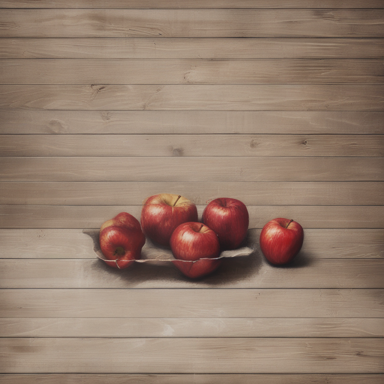

d3378258bcd1 constant increasing (1.0, 2.0) seed= 1337


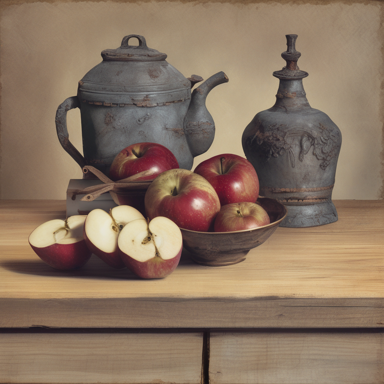

4b9789b4dda0 constant increasing (1.0, 2.0) seed= 42


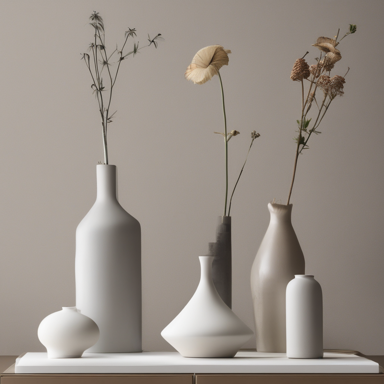

In [30]:
# Display a few generated images
for r in recs:
    print(r["experiment_id"], r["kind"], r["direction"], (r["w_min"], r["w_max"]), "seed=", r["seed"])
    display(Image.open(r["img_path"]).resize((384, 384)))


In [21]:
# minimal basesline
df = pd.read_csv("minimal_baseline.csv")
df

,experiment_group,experiment_id,kind,direction,w_min,w_max,num_steps,seed,prompt_id,prompt_text,params
0,MINIMAL_BASELINE,baseline_p1,constant,increasing,7.5,7.5,25,0,P1,"masterpiece, best quality, 3 red apples on a w...",{}
1,MINIMAL_BASELINE,baseline_p2,constant,increasing,7.5,7.5,25,0,P2,"masterpiece, best quality, 5 ceramic vases on ...",{}


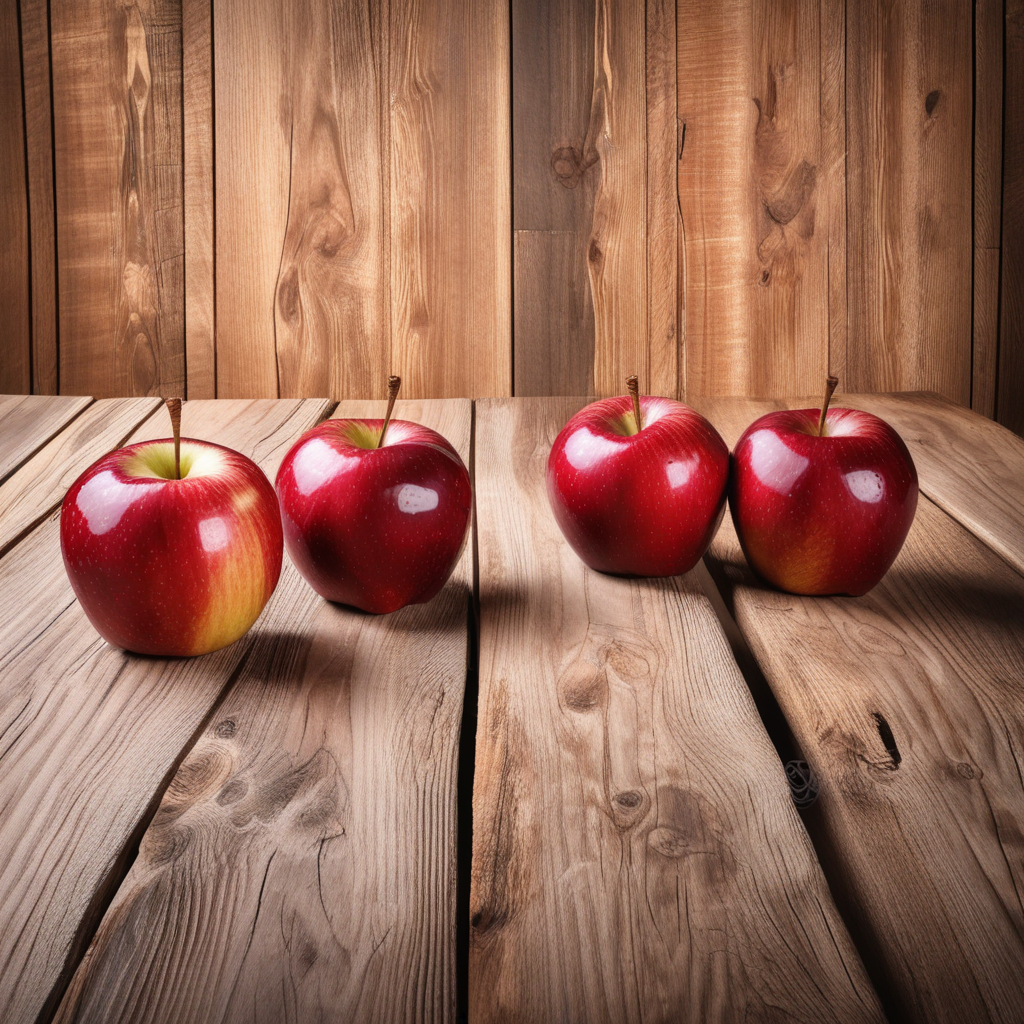

In [26]:
row = df.iloc[0]

scheduler_obj = create_scheduler(
    kind=row.kind,
    w_min=row.w_min,
    w_max=row.w_max,
    direction=row.direction,
)

img = generate_with_scheduler(
    prompt=row.prompt_text,
    neg_prompt=DEFAULT_NEG_PROMPT,
    scheduler_obj=scheduler_obj,
    steps=int(row.num_steps),
    seed=int(row.seed),
)

display(img)

In [31]:
import shutil
import os
from google.colab import files

# Path to the directory you want to download
source_dir = "/content/runs/EXP_B_EXTREME_TRADEOFF"
# Output zip filename (without extension)
output_filename = "EXP_B_EXTREME_TRADEOFF"

if os.path.exists(source_dir):
    print(f"Zipping {source_dir}...")
    # Create zip file
    shutil.make_archive(output_filename, 'zip', source_dir)

    zip_path = f"{output_filename}.zip"
    print(f"Downloading {zip_path}...")
    files.download(zip_path)
else:
    print(f"Directory not found: {source_dir}")

Zipping /content/runs/EXP_B_EXTREME_TRADEOFF...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>